# Exploratory Analysis

Ivan Tverdyi, Marcin Piotr Jochlik, Taras Kutsyk

24.06.2025

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy, chi2_contingency
import numpy as np

class DataDescription:
    # Constructor of the class DataDescription with specified elemnts of column types
    def __init__(self):
        self.DataName = 'in-vehicle-coupon-recommendation.csv'
        self.data = pd.read_csv(self.DataName)
        
        # Specified types of columns based on its values
        self.CatColumns = ['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus', \
                          'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', ]
        self.BinColumns = ['has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp']
        self.NumColumns = ['temperature']

    # Description - computes a list of the number of columns and number of unique value of each column 
    def Description(self):
        # Computing the number of columns
        print(f'Number of columns: {len(self.data.columns)}\n')
        print('Columns, type and number of unique values:\n')

        # Computing the number of unique values in each column 
        List = []
        for c in self.data.columns:
            r = self.data[c].unique()
            if c in self.CatColumns:
                List.append((c,'Cat', len(r)))
            elif c in self.BinColumns:
                List.append((c,'Bin', len(r)))
            else:
                List.append((c,'Num', len(r)))

        # After computing the list is sorted and printed
        List.sort(key = lambda x: x[2])
        for p in List:
            print(f'  {p[0]}: {p[1]}, {p[2]}')

    # NaNAnalysis - describe the proces of NaN droping and drops it 
    def NaNAnalysis(self):
        NanRow = self.data[self.data.isna().any(axis=1)]
        print(f'Percentage of NaN rows:  {round(len(NanRow)/len(self.data)*100, 1)} => Too hight value to remove NaN values by removing NaNs rows.\n')

        NanCol = self.data.columns[self.data.isna().any()].tolist()
        NanColDict = self.data.isna().sum()
        NanSum = sum(NanColDict)
        NanColDict = dict(NanColDict[NanColDict>0]/NanSum*100)
        print(f'Percentage o NaN columns:  {round(len(NanCol)/len(self.data.columns)*100, 1)} => Check the distribution of NaN values in columns.\n')
        
        plt.bar(NanColDict.keys(), NanColDict.values())
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Percentage')
        plt.title('Percentage of NaN values in columns')
        plt.show()
        print()
        print(f'From the hitogram we can see that the major amount of NaN values is collected in "car" column: {NanColDict['car']} \n => Check the NaN distribution after removing this column.\n')
        
        print('After removing "car" column\n')
        # Droping the 'car' column
        self.data = self.data.drop('car', axis = 1)
        NanRow = self.data[self.data.isna().any(axis=1)]
        print(f'Percentage of NaNs rows:  {round(len(NanRow)/len(self.data)*100, 1)} => The NaN percentage had rapidly collapsed.\n')
        
        NanCol = self.data.columns[self.data.isna().any()].tolist()
        NanColDict = self.data.isna().sum()
        NanSum = sum(NanColDict)
        NanColDict = dict(NanColDict[NanColDict>0]/NanSum*100)
        print(f'Percentage o Nan columns:  {round(len(NanCol)/len(self.data.columns)*100, 1)} => Check the distribution of NaN values in columns.\n')
        
        plt.bar(NanColDict.keys(), NanColDict.values())
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Percentage')
        plt.title('Percentage of NaN values in columns')
        plt.show()
        print('From the second plot we can see that the distribution of NaN values in columns is almosed equale and the Percentage of NaN row is very small.')
        print(' => Now it is better to remove all of the NaN rows then NaN columns or impute them with modes and medians.')

        # Droping rows with NaN values and resting indexis
        self.data = self.data.dropna()
        self.data = self.data.reset_index(drop=True)

    # ReplaceEspilon - for given epsilon, for every column merge the values with frequencity smaller than epsilon and replace their names with 'another'
    def ReplaceEpsilon(self, epsilon):
        # Geting description of dataset
        L = len(self.data)
        DictOld = self.CountData(norm = False)
        Col = self.data.columns

        # Creating the sorted list representation of description 
        List = []
        for c in Col:
            for f in DictOld[c].keys():
                List.append((c,f,DictOld[c][f]))
        List.sort(key = lambda x:x[2])

        # Creating the list of elemnts to replace
        ToReplace = []
        S = 0
        for p in List:
            if p[2]/L < epsilon:
                ToReplace.append((p[0], p[1]))
                print(f'Replaced in column {p[0]} fature {p[1]}: {p[2]} / {round(p[2]/L,4)} %')
                S += p[2]
            else: break

        # Replacing values
        for k in ToReplace:
            self.data[k[0]] = self.data[k[0]].replace(k[1], 'another')
        
        print(f'Total replaced elements: {S} / {round(S/L*100,1)} %')

    # CountData - counts number of unique values in columns. If norm = True -> the result is normalized, else -> the result is not normalized
    def CountData(self, norm):
        Col = self.data.columns
        Dict = {}
        for c in Col:
            Atr = dict(self.data[c].value_counts(normalize=norm))
            Atr = {str(c): Atr[c] for c in Atr}
            Dict[c] = Atr
        return Dict

    # DataBalance - describes the balance of data using Entropy ratio with graph visualization
    def DataBalance(self):
        # Calculating entropy of each column
        Dict  = self.CountData(True)
        Entropy = {c: round(entropy(list(Dict[c].values()), base = len(Dict[c].values())), 3) if c != 'toCoupon_GEQ5min' else round(entropy(list(Dict[c].values())), 3) for c in Dict.keys()}
        Col = self.data.columns

        # Defing the dictonary of colors to color the balance histograms
        Avg = {c: 1/len(Dict[c].keys()) for c in Col}
        AllColor = {}
        for c in Col:
            if c != 'occupation':
                Color = []
                for f in Dict[c]:
                    if Dict[c][f] >= Avg[c]:
                        Color.append('blue')
                    else:
                        Color.append('red')
                AllColor[c] = Color

        # Creating the graphs of all columns i.e. column 'occupation' is devided into two graphs beause of its number of possible values
        for c in Col:
            if c != 'occupation':
                plt.bar(Dict[c].keys(), Dict[c].values(), color = AllColor[c])
                plt.xticks(rotation=45, ha='right')
                plt.ylabel('Ratio')
                plt.title(f'Balance of {c} class (H = {Entropy[c]})')
                plt.show()

        # Creating graphs for 'occupation'
        OcUp = {f: Dict['occupation'][f] for f in Dict['occupation'].keys() if Dict['occupation'][f] >= Avg['occupation']}   
        plt.bar(OcUp.keys(), OcUp.values(), color = 'blue')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Ratio')
        plt.title(f'Balance of {'occupation'} class (H = {Entropy[c]})')
        plt.show()

        OcDown = {f: Dict['occupation'][f] for f in Dict['occupation'].keys() if Dict['occupation'][f] < Avg['occupation']}   
        plt.bar(OcDown.keys(), OcDown.values(), color = 'red')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Ratio')
        plt.title(f'Balance of {'occupation'} class')
        plt.show()

    # IndependenceTest - using chi2_contigency test mesures the part of depence pair in dataset under assumption that the column 'toCoupon_GEQ5min'
    # is not included in test
    def IndependeceTest(self):
        Col = list(self.data.columns)
        S = 0
        SFalse = 0
        print('Dependent colums:')
        for i in range(len(Col)-1):
            for j in range(1, len(Col)):
                if (i < j) and (Col[i] != 'toCoupon_GEQ5min') and (Col[j] != 'toCoupon_GEQ5min'):
                    S += 1
                    
                    # using numpy's crosstab and scipy.stats chi2_contingency test
                    CrossTable = pd.crosstab(self.data[Col[i]], self.data[Col[j]])
                    res = chi2_contingency(CrossTable)
                    if (res.pvalue > 0.05):
                        print(f'  {Col[i]} - {Col[j]} ')
                        SFalse += 1
        print(f'Ratio of dependence: {round(SFalse/S*100, 1)} %')

# Creating DataDescription instance

In [110]:
d = DataDescription()

# Describing dataset

In [113]:
d.Description()

Number of columns: 26

Columns, type and number of unique values:

  toCoupon_GEQ5min: Bin, 1
  expiration: Cat, 2
  gender: Cat, 2
  has_children: Bin, 2
  toCoupon_GEQ15min: Bin, 2
  toCoupon_GEQ25min: Bin, 2
  direction_same: Bin, 2
  direction_opp: Bin, 2
  Y: Num, 2
  destination: Cat, 3
  weather: Cat, 3
  temperature: Num, 3
  passanger: Cat, 4
  time: Cat, 5
  coupon: Cat, 5
  maritalStatus: Cat, 5
  education: Cat, 6
  car: Num, 6
  Bar: Cat, 6
  CoffeeHouse: Cat, 6
  CarryAway: Cat, 6
  RestaurantLessThan20: Cat, 6
  Restaurant20To50: Cat, 6
  age: Cat, 8
  income: Cat, 9
  occupation: Cat, 25


# Performing NaN Analysis

Percentage of NaN rows:  99.1 => Too hight value to remove NaN values by removing NaNs rows.

Percentage o NaN columns:  23.1 => Check the distribution of NaN values in columns.



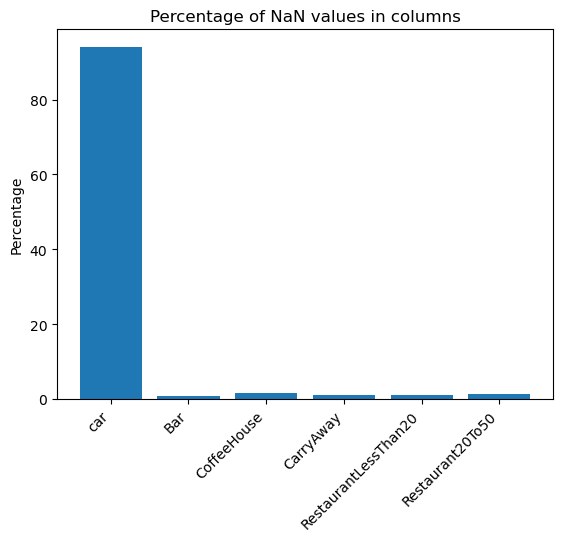


From the hitogram we can see that the major amount of NaN values is collected in "car" column: 94.06133133881825 
 => Check the NaN distribution after removing this column.

After removing "car" column

Percentage of NaNs rows:  4.8 => The NaN percentage had rapidly collapsed.

Percentage o Nan columns:  20.0 => Check the distribution of NaN values in columns.



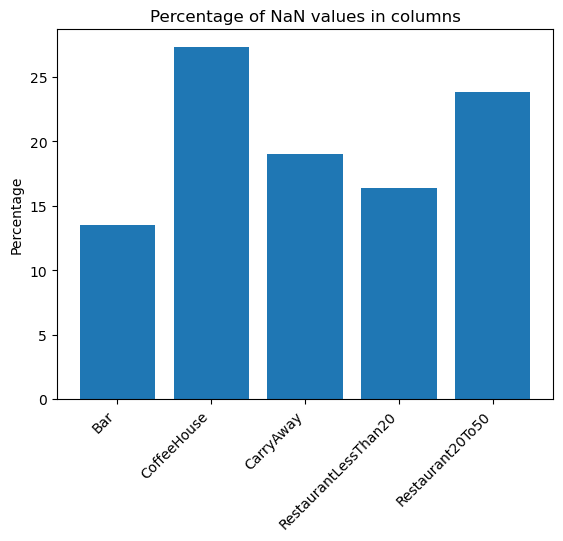

From the second plot we can see that the distribution of NaN values in columns is almosed equale and the Percentage of NaN row is very small.
 => Now it is better to remove all of the NaN rows then NaN columns or impute them with modes and medians.


In [116]:
d.NaNAnalysis()

# Replacing the epsilon small values

In [119]:
d.ReplaceEpsilon(0.01)

Replaced in column occupation fature Farming Fishing & Forestry: 43 / 0.0036 %
Replaced in column occupation fature Building & Grounds Cleaning & Maintenance: 44 / 0.0036 %
Replaced in column education fature Some High School: 88 / 0.0073 %
Replaced in column occupation fature Production Occupations: 88 / 0.0073 %
Replaced in column maritalStatus fature Widowed: 108 / 0.0089 %
Total replaced elements: 371 / 3.1 %


# Describing the balance of columns in data

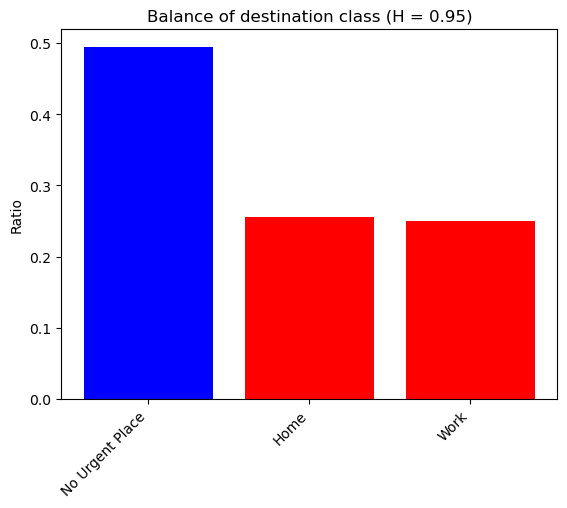

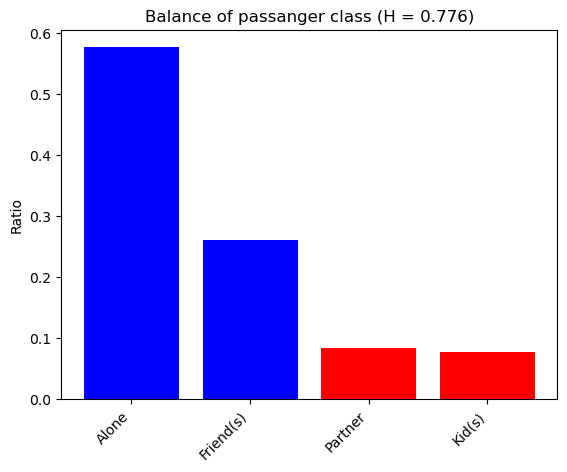

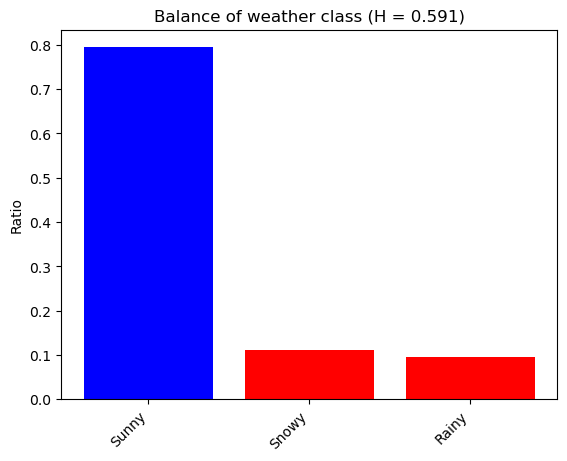

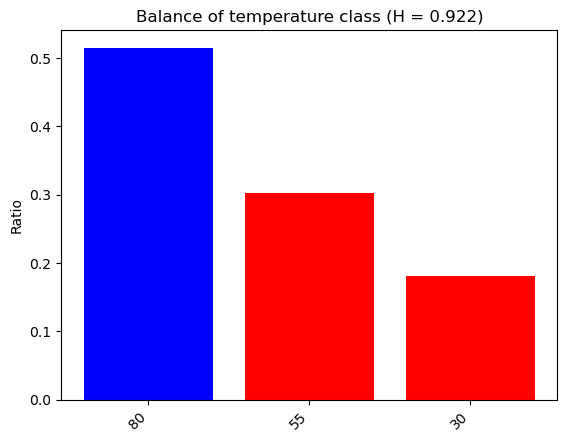

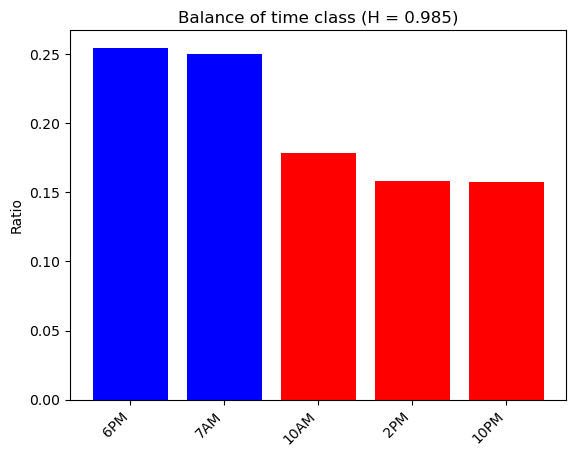

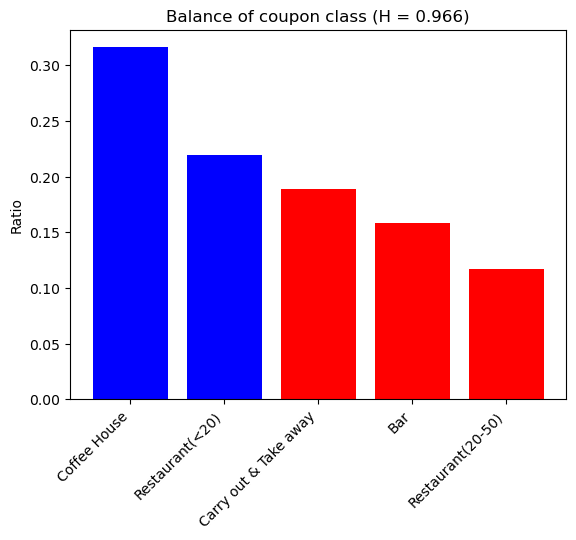

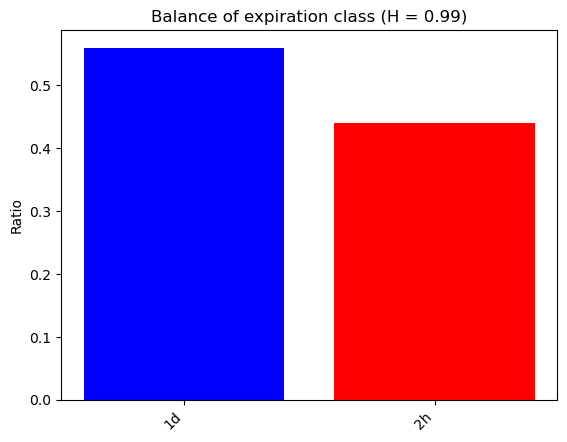

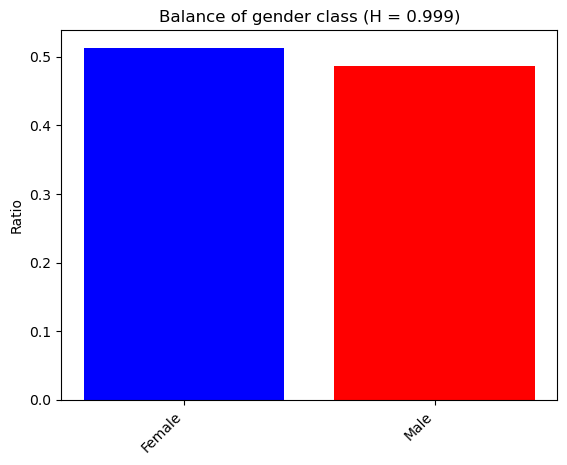

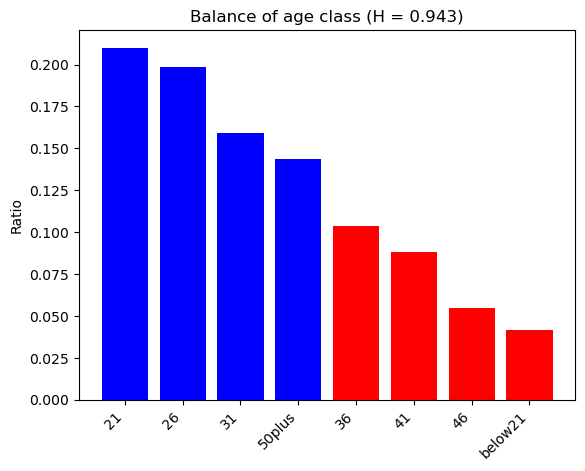

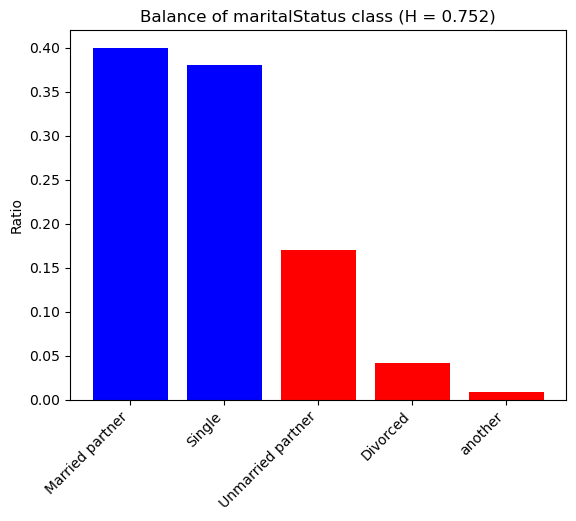

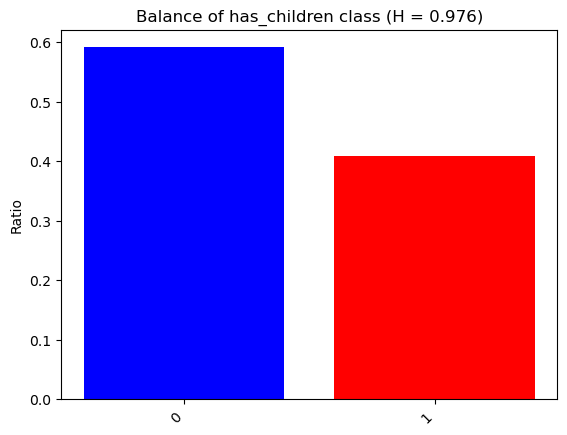

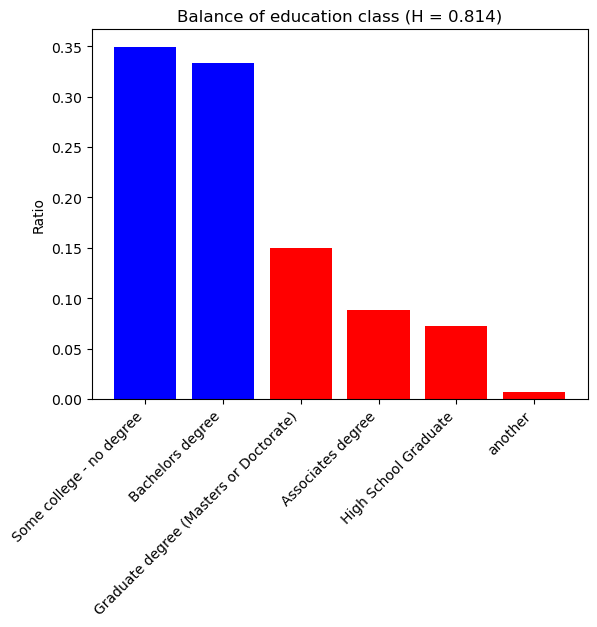

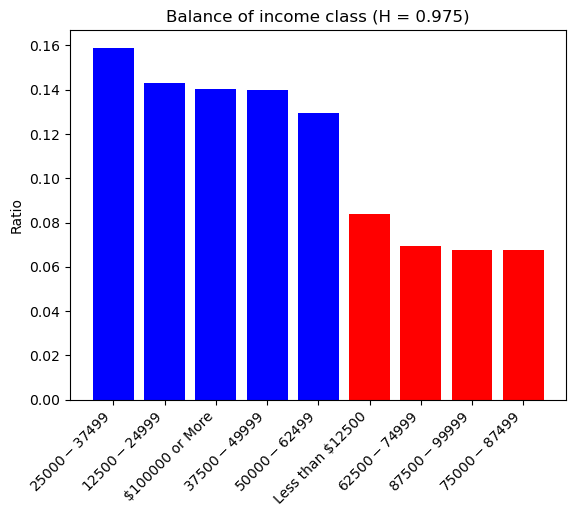

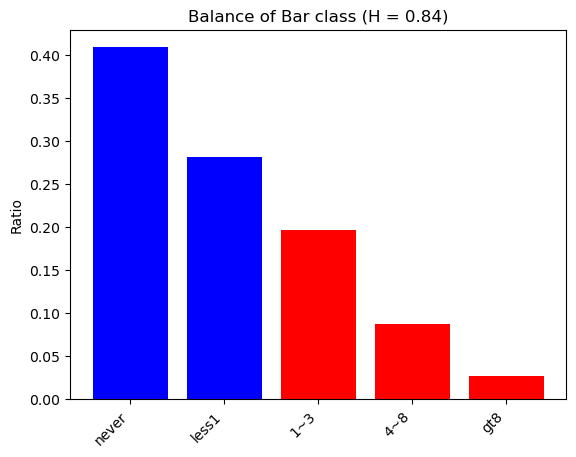

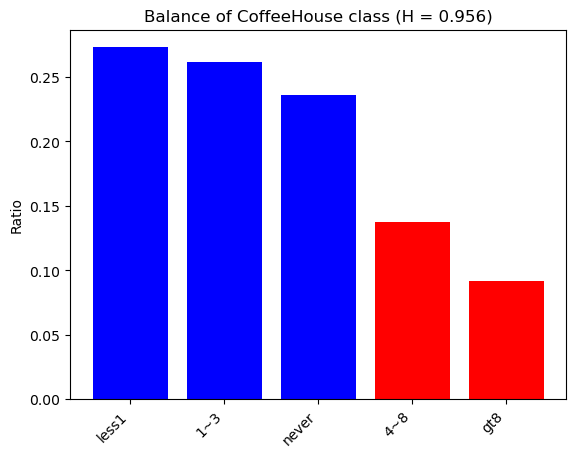

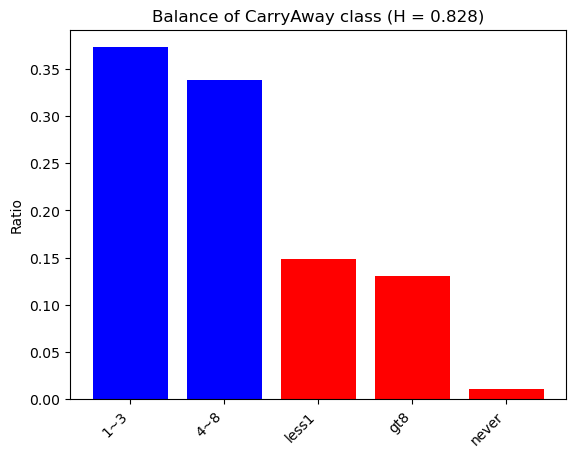

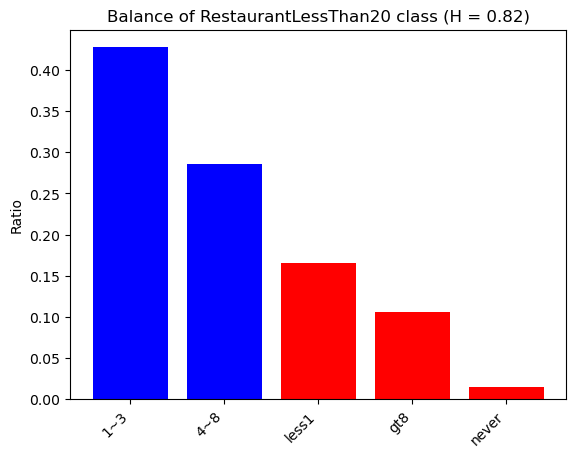

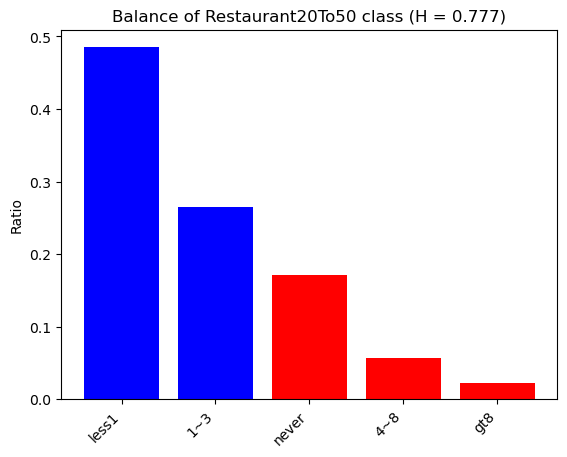

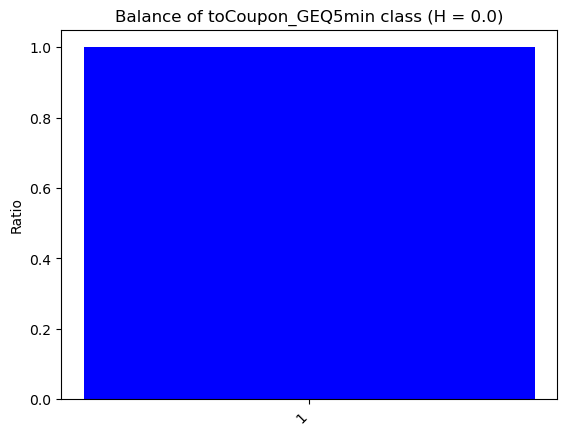

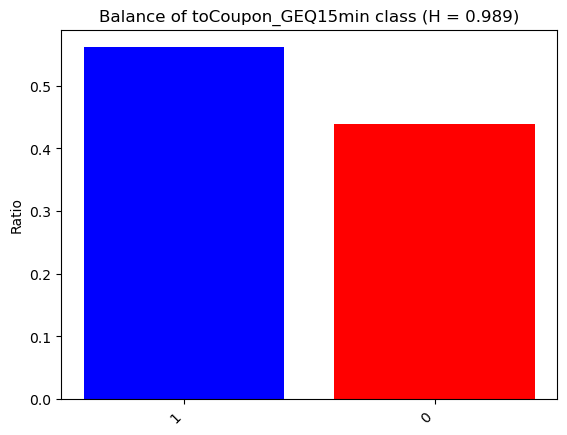

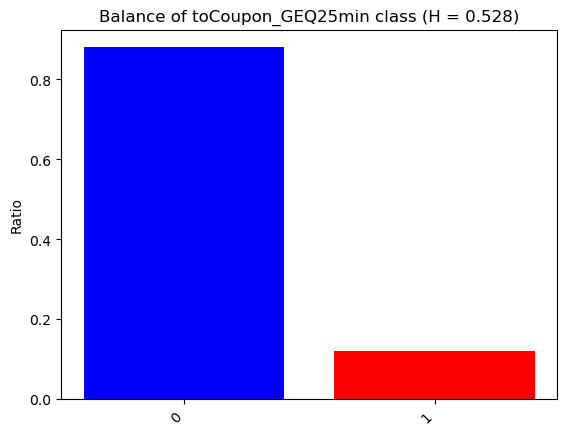

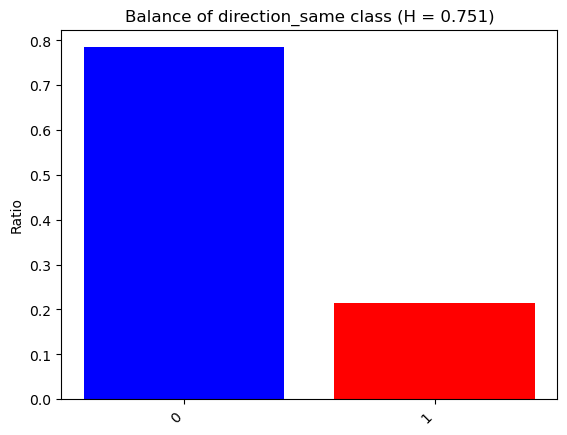

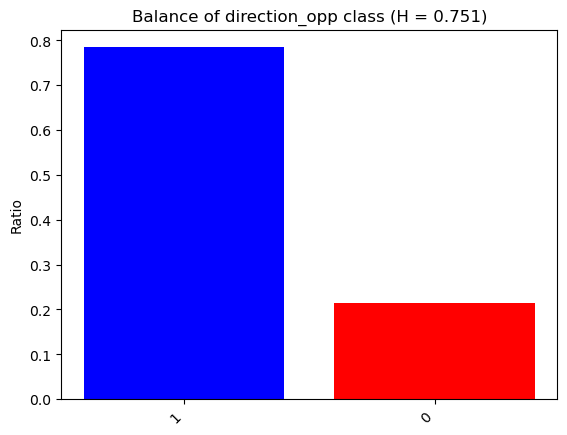

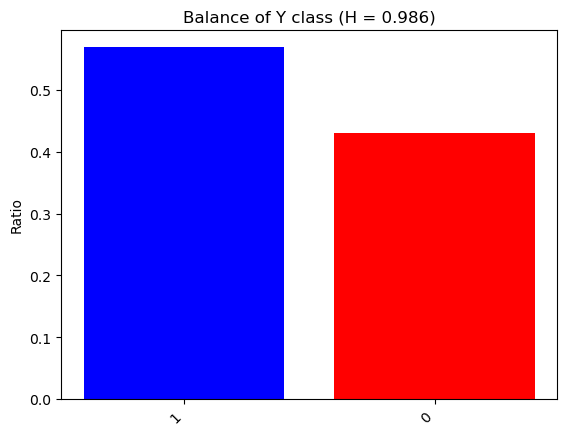

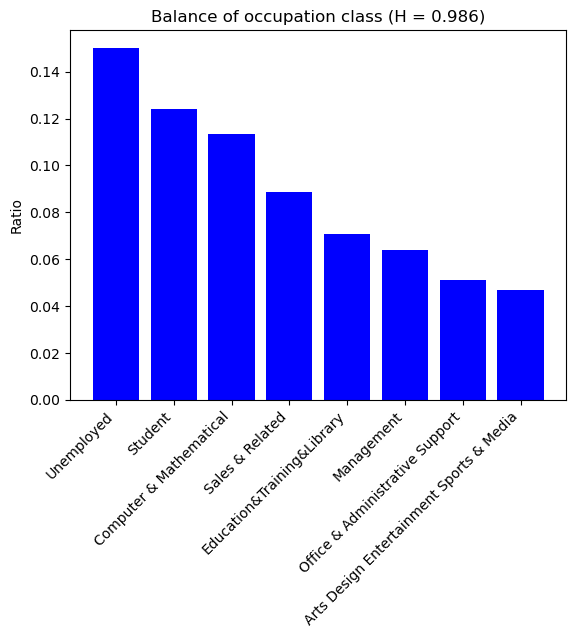

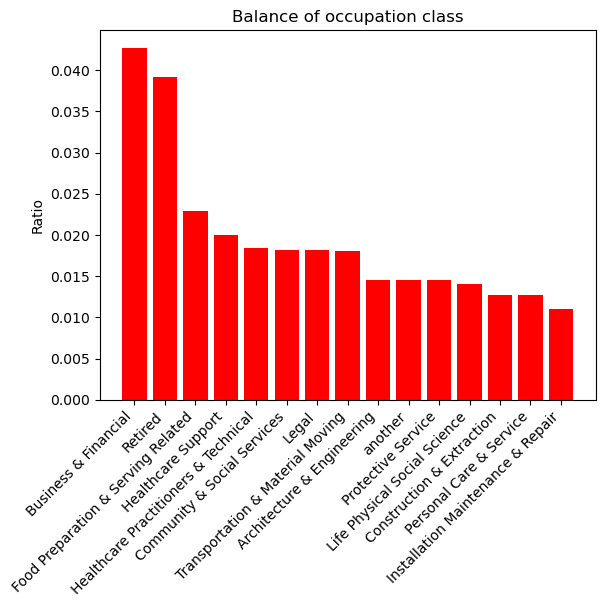

In [122]:
d.DataBalance()

# Performing the Chi square test

In [124]:
d.IndependeceTest()

Dependent colums:
  destination - gender 
  destination - age 
  destination - education 
  destination - income 
  destination - Bar 
  destination - CoffeeHouse 
  destination - CarryAway 
  destination - RestaurantLessThan20 
  destination - Restaurant20To50 
  weather - maritalStatus 
  weather - has_children 
  temperature - Bar 
  temperature - CoffeeHouse 
  time - gender 
  time - age 
  time - education 
  time - income 
  time - Bar 
  time - CoffeeHouse 
  time - CarryAway 
  time - RestaurantLessThan20 
  time - Restaurant20To50 
  coupon - gender 
  coupon - age 
  coupon - education 
  coupon - occupation 
  coupon - income 
  coupon - Bar 
  coupon - CoffeeHouse 
  coupon - CarryAway 
  coupon - RestaurantLessThan20 
  coupon - Restaurant20To50 
  expiration - gender 
  expiration - age 
  expiration - education 
  expiration - income 
  expiration - Bar 
  expiration - CoffeeHouse 
  expiration - CarryAway 
  expiration - RestaurantLessThan20 
  expiration - Restaurant2